# **IMPORTS**

In [19]:
# data manipulation
import math
import inflection
import pandas as pd
import numpy  as np 

from datetime              import date, datetime, timedelta

# data visualization
from tabulate            import tabulate
from IPython.display     import Image
import matplotlib.pyplot as plt
import seaborn as sns

## **Helper Functions**

## **Loading data**

In [2]:
df_sales_raw = pd.read_csv('C:/Users/victo/repos/Sales_Prediction/data/train.csv', low_memory=False)
df_store_raw = pd.read_csv('C:/Users/victo/repos/Sales_Prediction/data/store.csv', low_memory=False)

# merge to define the main dataset
df_raw = pd.merge(df_sales_raw, df_store_raw, how='left', on='Store')

# **DATA DESCRIPTION**

In this step we will analyze, clean and pre-process the data for our future analysis.

In [3]:
# set df1 as the main dataset
df1 = df_raw.copy()

## **Rename Columns**

In [4]:
# CamelCase original columns format 
cols_old = df1.columns

# rename columns to snake_case format
df1.columns = list(map(lambda x: inflection.underscore(x), cols_old))

## **Data Dimensions**

In [5]:
print(f'Number of Rows: {df1.shape[0]}')
print(f'Number of Cols: {df1.shape[1]}')

Number of Rows: 1017209
Number of Cols: 18


Analyzing the dimensions of the data, it will be possible to carry out the analysis by pandas and without the need for a server.

## **Data Types**

In [6]:
# Change columns 'date' to datetime format
df1['date'] = pd.to_datetime(df1['date'])

## **Check NA**

In [7]:
# checking if there are NAs in the dataset
print(df1.isna().sum())

store                                0
day_of_week                          0
date                                 0
sales                                0
customers                            0
open                                 0
promo                                0
state_holiday                        0
school_holiday                       0
store_type                           0
assortment                           0
competition_distance              2642
competition_open_since_month    323348
competition_open_since_year     323348
promo2                               0
promo2_since_week               508031
promo2_since_year               508031
promo_interval                  508031
dtype: int64


In [8]:
print('NAs by Store:')

# checking which stores do not have a distance to the nearest competitor
competition_distance_null = list(df_store_raw[df_store_raw['CompetitionDistance'].isnull()]['Store'])
print(f'stores that have no competition_distance: {competition_distance_null}')

# checking how many stores do not have the competition start date
competition_date_null = len(df1[(df1['competition_open_since_month'].isnull()) & (df1['competition_open_since_year'].isnull())]['store'].unique())
print(f'{competition_date_null} stores have no competition_open_since_month & competition_open_since_year')

# verifying how many stores did not join the extended promotion
stores_without_promo2 = len(df1[df1['promo2'] == 0]['store'].unique())
print(f'{stores_without_promo2} stores did not adhere to promo2 (NAs in columns: promo2_since_week & promo2_since_year & promo_interval )')

NAs by Store:
stores that have no competition_distance: [291, 622, 879]
354 stores have no competition_open_since_month & competition_open_since_year
544 stores did not adhere to promo2 (NAs in columns: promo2_since_week & promo2_since_year & promo_interval )


## **Fillout NA**

We can replace the NAs with data obtained through the analysis of the feature's behavior made by ML algorithms, however, for this project we will fill the NAs based on the **assumptions made in view of the understanding of the business**.

In [9]:
# competition_distance (03 stores with NA values)
df1['competition_distance'] = df1['competition_distance'].apply(lambda x: 100000 if pd.isna(x) else x)

# competition_open_since_month & competition_open_since_year (354 stores with NA values)
df1['competition_open_since_month'].fillna(1, inplace=True) 
df1['competition_open_since_year'].fillna(2013, inplace=True) 

# promo2_since_week & promo2_since_year (544 stores with NA values)
df1['promo2_since_week'].fillna(0, inplace=True) 
df1['promo2_since_year'].fillna(0, inplace=True)

# promo_interval (544 stores with NA values)
df1['promo_interval'].fillna(0, inplace=True) 

**competition_distance:** 
* **Description**: distance in meters to the nearest competidor store
* **Assumption**: it's NA because there is no competidor close or it is too far away.
* **Realized**: a much greater distance than the maximum was placed, meaning there is no competition

**competition_open_since_month & competition_open_since_year**
* **Description**: approximate year and month of the time the nearest competitor was opened
* **Assumption**: it's NA because there is no competidor close, or existis, but we don't know when it opened (if there is a close competitor, there is a competition start date).
* **Realized**: the month/year of the first sale date of each store was placed inside the column row

**promo2_since_week & promo2_since_year**
* **Description**: year and calendar week when the store started participating in Promo2
* **Assumption**: it's NA because the store decided not to participate in the Promo2, so there is no start date
* **Realized**: a 0 was placed on the row

**promo_interval**
* **Description**: consecutive intervals Promo2 is started
* **Assumption**: it's NA because the store decided not to participate in the Promo2, so there is no interval.
* **Realized**: a 0 was placed on the row

## **Change Types**

In [10]:
# change columns to int format
df1['competition_open_since_month'] = df1['competition_open_since_month'].astype('int64') 
df1['competition_open_since_year'] = df1['competition_open_since_year'].astype('int64') 
df1['promo2_since_week'] = df1['promo2_since_week'].astype('int64') 
df1['promo2_since_year'] = df1['promo2_since_year'].astype('int64') 

It was identified that the columns **competition_open_since_month, competition_open_since_year, promo2_since_week and promo2_since_year** were not in the correct format, so a change was made to the correct format **int**.

## **Descriptive Statistical**

We will perform descriptive statistics on the data to gain initial business knowledge and identify errors.

In [11]:
# separate data between numeric and categorical
num_attributes = df1.select_dtypes(include=['int64', 'float64'])
cat_attributes = df1.select_dtypes(exclude=['int64', 'float64', 'datetime64[ns]'])

### **Numerical Attributes**

In [12]:
# central tendency metrics - mean, median
mean   = num_attributes.mean()
median = num_attributes.median()

# dispersion metrics - min, max, range, std, skew, kurtosis
min      = num_attributes.min()
max      = num_attributes.max()
range    = num_attributes.max() - num_attributes.min()
std      = num_attributes.std()
skew     = num_attributes.skew()
kurtosis = num_attributes.kurtosis()

# concat central and dispersion metrics
aux1 = pd.concat([min, max, range, mean, median, std, skew, kurtosis], axis=1).reset_index()
aux1.columns = ['attributes', 'min', 'max', 'range', 'mean', 'median', 'std', 'skew', 'kurtosis']
aux1

,attributes,min,max,range,mean,median,std,skew,kurtosis
0,store,1.0,1115.0,1114.0,558.429727,558.0,321.908651,-0.000955,-1.200524
1,day_of_week,1.0,7.0,6.0,3.998341,4.0,1.997391,0.001593,-1.246873
2,sales,0.0,41551.0,41551.0,5773.818972,5744.0,3849.926175,0.641460,1.778375
3,customers,0.0,7388.0,7388.0,633.145946,609.0,464.411734,1.598650,7.091773
4,open,0.0,1.0,1.0,0.830107,1.0,0.375539,-1.758045,1.090723
5,promo,0.0,1.0,1.0,0.381515,0.0,0.485759,0.487838,-1.762018
6,school_holiday,0.0,1.0,1.0,0.178647,0.0,0.383056,1.677842,0.815154
7,competition_distance,20.0,100000.0,99980.0,5675.712376,2330.0,9085.163758,4.637208,35.287543
8,competition_open_since_month,1.0,12.0,11.0,5.244756,4.0,3.928522,0.311511,-1.422995
9,competition_open_since_year,1900.0,2015.0,115.0,2010.060208,2012.0,5.340757,-7.884662,139.910688


**sales & customers** minimum of 0 means the days when stores are closed

**competition_distance** maximum equal to 100k as we replaced the NAs by a distance much greater than the 75860 in the last step.

**promo2_since_week & promo2_since_year**: minimum equal to 0 as we changed the NAs by 0 in the last step.

### **Categorical Attributes**

In [13]:
# check which columns we are going to perform the analysis
cat_attributes.apply(lambda x: x.unique().shape[0])

state_holiday     4
store_type        4
assortment        3
promo_interval    4
dtype: int64

The analysis will be performed on the columns **state_holiday**, **store_type**, **assortment**.

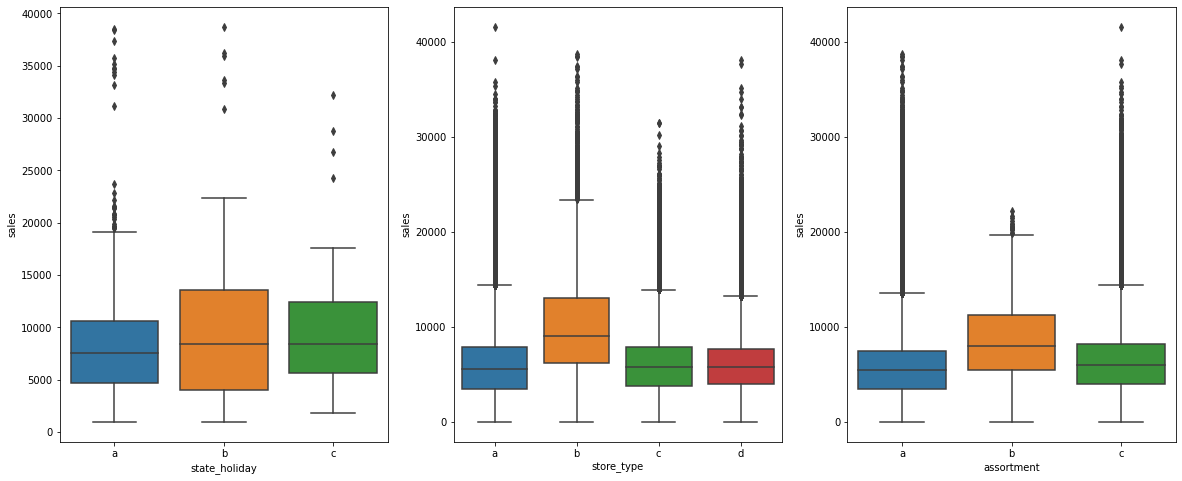

In [18]:
# setting the plot size
plt.rcParams['figure.figsize'] = (20, 8)

plt.subplot(1, 3, 1)
# state_holiday (with dataset filtered by days with sales greater than 0 and which are holidays)
sns.boxplot(x='state_holiday', y='sales', data=df1[(df1['sales'] > 0) & (df1['state_holiday'] != '0')]);

# store_type
plt.subplot(1, 3, 2)
sns.boxplot(x='store_type', y='sales', data=df1, order=['a', 'b', 'c', 'd']);

# assortment
plt.subplot(1, 3, 3)
sns.boxplot(x='assortment', y='sales', data=df1, order=['a', 'b', 'c']);

**state_holiday:** We observed that type **b** is the one with the largest interquartile range (IQR) between state holidays, however its median does not differ much from type **c**, type **a** is the one with the lowest median and lowest IQR, but still very similar to the other types.

**store_type:** Of the 4 types of stores, the only one that stands out with a median and a higher IQR is type **b**, all other types are below and with measurements very similar.

**assortment:** The store with assortment type **b** has the highest median among the 3, with type **c** being very similar to **a**, but with a slightly higher median.

# **FEATURE ENGINEERING**

In this step, we will raise hypotheses and derive the necessary features to carry out the exploratory data analysis (EDA) in the future.

In [20]:
# copy dataset
df2 = df1.copy()

## **Mind Map Hypothesis**

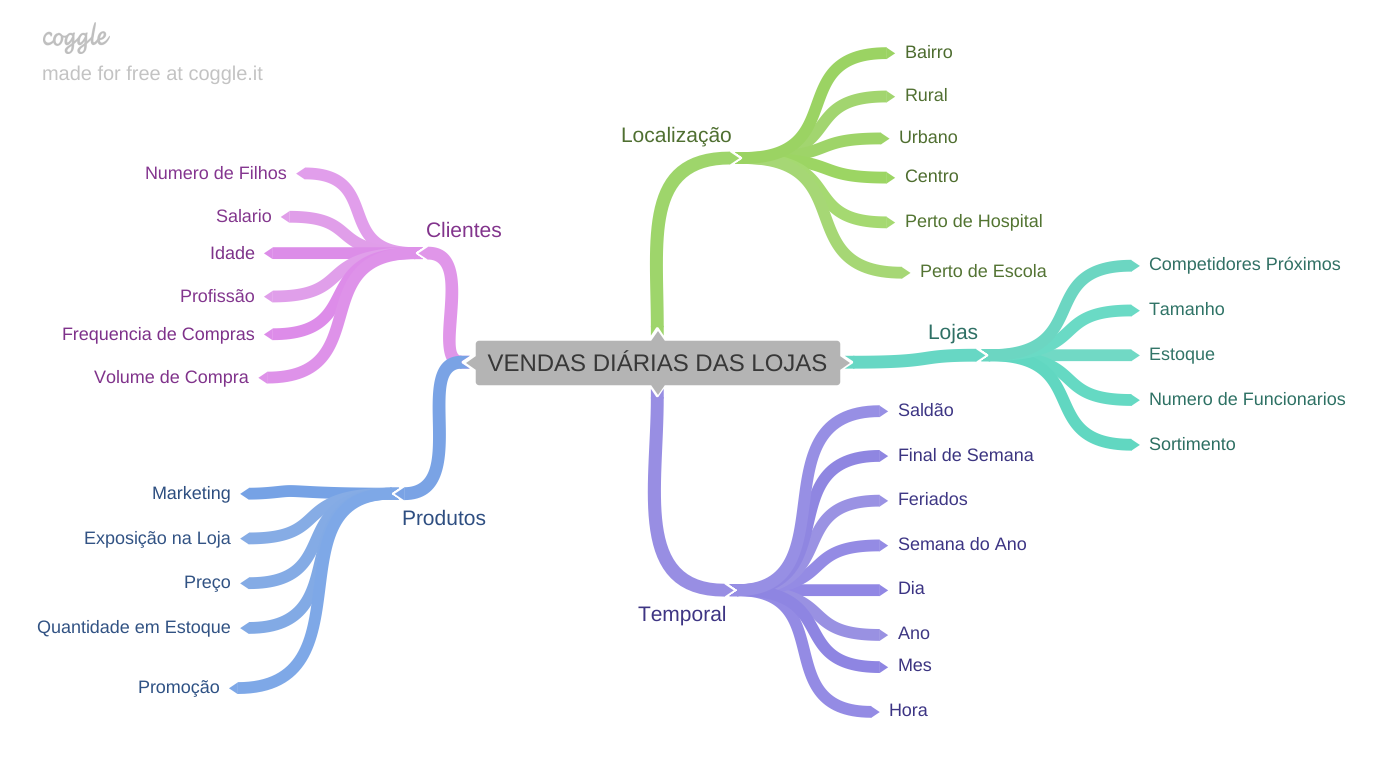

In [21]:
Image('C:/Users/victo/repos/Sales_Prediction/img/MindMapHypothesis.png')

## **Hypothesis Creation**

### **Store Hypothesis**

**1**. Stores with more employees should sell more.

**2**. Stores with more inventory capacity should sell more.

**3**. Larger stores should sell more.

**4**. Stores with larger assortments should sell more.

**5**. Stores with closer competitors should sell less.

**6**. Stores with longer-term competitors should sell more.

### **Product Hypothesis**

**1**. Stores that invest more in Marketing should sell more.

**2**. Stores with greater product exposure should sell more.

**3**. Stores with products at a lower price should sell more.

**5**. Stores with more aggressive promotions (bigger discounts), should sell more.

**6**. Stores with promotions active for longer should sell more.

**7**. Stores with more promotion days should sell more.

**8**. Stores with more consecutive promotions should sell more.

### **Time Hypothesis**

**1**. Stores open during the Christmas holiday should sell more.

**2**. Stores should sell more over the years.

**3**. Stores should sell more in the second half of the year.

**4**. Stores should sell more after the 10th of each month.

**5**. Stores should sell less on weekends.

**6**. Stores should sell less during school holidays.

## **Final List of Hypothesis**

**1**. Stores with larger assortments should sell more.

**2**. Stores with closer competitors should sell less.

**3**. Stores with longer-term competitors should sell more.

**4**. Stores with promotions active for longer should sell more.

**5**. Stores with more promotion days should sell more.

**6**. Stores with more consecutive promotions should sell more.

**7**. Stores open during the Christmas holiday should sell more.

**8**. Stores should sell more over the years.

**9**. Stores should sell more in the second half of the year.

**10**. Stores should sell more after the 10th of each month.

**11**. Stores should sell less on weekends.

**12**. Stores should sell less during school holidays.

## **Feature Engineering**

Based on the hypothesis raised above, we will derive features from the original dataset to perform their validation.

In [22]:
# table with the necessary features for each hypothesis
hip_tab = [['Hypothesis', 'Required Features', 'Features to Create'],
           ['1.Stores with larger assortments should sell more', 'assortment & sales', '-'],
           ['2.Stores with closer competitors should sell less','competition_distance & sales', '-'],
           ['3.Stores with longer-term competitors should sell more', 'time_of_competition & sales', 'time_of_competition'],
           ['4.Stores with promotions active for longer should sell more', 'time_of_promo2 & sales', 'time_of_promo2'],
           ['5.Stores with more promotion days should sell more', 'sum_of_promo_days & sales', 'sum_of_promo_days'],
           ['6.Stores with more consecutive promotions should sell more', 'promo & promo2 & sales', '-'],
           ['7.Stores open during the Christmas holiday should sell more', 'state_holiday & sales', '-'],
           ['8.Stores should sell more over the years', 'year & sales', 'year'],
           ['9.Stores should sell more in the second half of the year', 'month & sales', 'month'],
           ['10.Stores should sell more after the 10th of each month', 'day_of_month x sales', 'day_of_month'],
           ['11.Stores should sell less on weekends', 'day_of_week & sales', '-'],
           ['12.Stores should sell less during school holidays', 'school_holiday & sales', '-']]

print( tabulate(hip_tab, headers='firstrow', tablefmt='fancy_grid'))

╒═════════════════════════════════════════════════════════════╤══════════════════════════════╤══════════════════════╕
│ Hypothesis                                                  │ Required Features            │ Features to Create   │
╞═════════════════════════════════════════════════════════════╪══════════════════════════════╪══════════════════════╡
│ 1.Stores with larger assortments should sell more           │ assortment & sales           │ -                    │
├─────────────────────────────────────────────────────────────┼──────────────────────────────┼──────────────────────┤
│ 2.Stores with closer competitors should sell less           │ competition_distance & sales │ -                    │
├─────────────────────────────────────────────────────────────┼──────────────────────────────┼──────────────────────┤
│ 3.Stores with longer-term competitors should sell more      │ time_of_competition & sales  │ time_of_competition  │
├───────────────────────────────────────────────────────

In [23]:
# day - extract just the sales's day
df2['day'] = df2['date'].dt.day

# month - extract just the sales's month
df2['month'] = df2['date'].dt.month

# year - extract just the sales's year 
df2['year'] = df2['date'].dt.year

# week_of_year - extract the week's number of the year
df2['week_of_year'] = df2['date'].dt.isocalendar().week.astype('int64')

# year_week - extract the year and the week_of_year together
df2['year_week'] = df2['date'].dt.strftime('%Y-%W')

# is_promo2 - shows if the sale was made during the promo2's interval
month_map = {1: 'Jan', 2: 'Feb', 3: 'Mar', 4: 'Apr', 5: 'May', 6: 'Jun', 7: 'Jul', 8: 'Aug', 9: 'Sep', 10: 'Oct', 11: 'Nov', 12: 'Dec'}
df2['month_map'] = df2['date'].dt.month.map(month_map)
df2['is_promo2'] = df2[['month_map', 'promo_interval']].apply(lambda x: 0 if x['promo_interval'] == 0 else 1 if x['month_map'] in x['promo_interval'].split(',') else 0, axis=1)

# competition_time_month - time in months since the competition started
df2['competition_since'] = pd.to_datetime(df2['competition_open_since_year'].astype(str) + '-' + df2['competition_open_since_month'].astype(str) + '-1')
df2['competition_time_month'] = ((df2['date'] - df2['competition_since']) / 30).dt.days

# promo_since - time in weeks since the promotion started
df2['promo2_since'] = df2['promo2_since_year'].astype(str) + '-' + df2['promo2_since_week'].astype(str) + '-1'
df2['promo2_since'] = df2['promo2_since'].apply(lambda x: 0 if x == '0-0-1' else (datetime.strptime(x, '%Y-%W-%w')) - timedelta(days=7))
df2['promo2_time_week'] = df2.apply(lambda x: 0 if x['promo2_since'] == 0 else ((x['date'] - x['promo2_since']) / 7).days, axis=1)

# change the letters to the names of the assortment types
df2['assortment'] = df2['assortment'].map({'a': 'basic' , 'b': 'extra', 'c': 'extended'})

# change the letters to the names of state holidays
df2['state_holiday'] = df2['state_holiday'].map({'0': 'regular_day', 'a': 'public_holiday' , 'b': 'easter_holiday', 'c': 'christmas'})

In [24]:
# check data types
df2.dtypes

store                                    int64
day_of_week                              int64
date                            datetime64[ns]
sales                                    int64
customers                                int64
open                                     int64
promo                                    int64
state_holiday                           object
school_holiday                           int64
store_type                              object
assortment                              object
competition_distance                   float64
competition_open_since_month             int64
competition_open_since_year              int64
promo2                                   int64
promo2_since_week                        int64
promo2_since_year                        int64
promo_interval                          object
day                                      int64
month                                    int64
year                                     int64
week_of_year 